In [2]:
from Bio import Phylo
import pickle
import numpy as np
import pandas as pd
import os
from io import StringIO
from collections import Counter
import ete3
import re
os.chdir('../')

In [3]:
from mtDNAsim.sim_utils import *

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
# tree = Phylo.read('/data3/wangkun/mtsim_res/res_1113/linear_/449346/linear_tree_gt_449346.nwk', format='newick')

In [5]:
path = '/data3/wangkun/mtsim_res/res_0415/'

In [6]:
for model in ['linear_', 'linear_const', 'bifurcated_', 'bifurcated_const']:
    for simid in tqdm(os.listdir(path+model)):
        # for s in ['0.9', '0.95', '0.25']:
        with open(f"{path}{model}/{simid}/{model.split('_')[0].replace('bifurcated', 'bif')}_tree_gt_{simid}.nwk", 'r') as f:
            tree_nwk = f.readline()
            cell_type = f.readline()
        with open(f"{path}{model}/{simid}/{model.split('_')[0].replace('bifurcated', 'bif')}_tree_gt_{simid}_1.nwk", 'w') as f:
            f.write(tree_nwk)
        with open(f"{path}{model}/{simid}/{model.split('_')[0].replace('bifurcated', 'bif')}_{simid}_cell_type.csv", 'w') as f:
            f.write(cell_type)           

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
for model in ['bifurcated_', 'bifurcated_const']:
    for simid in tqdm(os.listdir(path+model)):
        # print(simid)
        if not simid in ['123456']:
            continue
        for s in ['0.9', '0.95', '0.25']:
            try:
                if 'const' in model:
                    mt_800rs = pickle.load(open(f'{path}{model}/{simid}/mt_allmuts_const_0.1_{simid}_800_0.4_{s}_rs.pkl', 'rb'))
                else:
                    mt_800rs = pickle.load(open(f'{path}{model}/{simid}/mt_allmuts_mid_0.1_{simid}_800_0.4_{s}_rs.pkl', 'rb'))
                mt_800rs = rs_cvt(mt_800rs)

                with open(f"{path}{model}/{simid}/{model.split('_')[0].replace('bifurcated', 'bif')}_tree_gt_{simid}.nwk", 'r') as f:
                    tree_nwk = f.readline()
                tree = ete3.Tree(tree_nwk.replace('\n', ';'), format=1)
                sel_cells = [re.findall('<.+>', i)[0] for i in mt_800rs.keys()]
                tree.prune(list(set(sel_cells)))
                cnt = Counter(sel_cells)

                tree = Phylo.read(StringIO(tree.write()), format='newick')
                for i in tree.get_terminals():
                    i.branch_length = 1
                for i in tree.get_nonterminals():
                    i.branch_length = 1

                for clade_name in cnt:
                    clade = tree.find_any(name=clade_name)
                    pseudo_clades = Phylo.BaseTree.Clade(branch_length=1)
                    for _ in range(int(np.log2(cnt[clade_name]))):
                        pseudo_clades.clades = [deepcopy(pseudo_clades), deepcopy(pseudo_clades)]
                    n_bif = cnt[clade_name] - len(pseudo_clades.get_terminals())
                    for ind, cl in enumerate(pseudo_clades.get_terminals()):
                        if ind < cnt[clade_name] - len(pseudo_clades.get_terminals()):
                            cl.clades = [Phylo.BaseTree.Clade(branch_length=1), Phylo.BaseTree.Clade(branch_length=1)]
                    for ind, cl in enumerate(pseudo_clades.get_terminals()):
                        cl.name = f'{clade_name}_{ind}'
                    clade.clades = pseudo_clades.clades

                trim_tree = StringIO()
                Phylo.write(tree, trim_tree, format='newick')

                leave = tree.get_terminals()
                sel_cells = [leave[i].name for i in np.random.choice(range(len(tree.get_terminals())), 1000, replace=False)]
                tree = ete3.Tree(trim_tree.getvalue(), format=1)
                tree.prune(sel_cells)
                tree = Phylo.read(StringIO(tree.write()), format='newick')
                Phylo.write(tree, f'{path}{model}/{simid}/clonal_expansion_tree_{s}_800.nwk', format='newick')
            except:
                None

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
for gen in [100, 300]:
    for mu in [0.4]:
        for simid in tqdm(os.listdir(path)):
            if simid[0] in 'r,n,o'.split(','):
                continue
            if 'const' in path.split('_')[-1]:
                mt_800rs = pickle.load(open(f'{path}{simid}/mt_allmuts_const_0.1_{simid}_{gen}_{mu}_rs.pkl', 'rb'))
            else:
                mt_800rs = pickle.load(open(f'{path}{simid}/mt_allmuts_mid_0.1_{simid}_{gen}_{mu}_rs.pkl', 'rb'))
            mt_800rs = rs_cvt(mt_800rs)
            # mtfreq = mut_freq(mt_800rs)

            with open(f'{path}{simid}/linear_tree_gt_{simid}.nwk', 'r') as f:
                tree_nwk = f.readline()
            tree = ete3.Tree(tree_nwk.replace('\n', ';'), format=1)
            sel_cells = [re.findall('<.+>', i)[0] for i in mt_800rs.keys()]
            tree.prune(list(set(sel_cells)))
            cnt = Counter(sel_cells)

            tree = Phylo.read(StringIO(tree.write()), format='newick')
            for i in tree.get_terminals():
                i.branch_length = 1
            for i in tree.get_nonterminals():
                i.branch_length = 1

            for clade_name in cnt:
                clade = tree.find_any(name=clade_name)
                pseudo_clades = Phylo.BaseTree.Clade(branch_length=1)
                for _ in range(int(np.log2(cnt[clade_name]))):
                    pseudo_clades.clades = [deepcopy(pseudo_clades), deepcopy(pseudo_clades)]
                n_bif = cnt[clade_name] - len(pseudo_clades.get_terminals())
                for ind, cl in enumerate(pseudo_clades.get_terminals()):
                    if ind < cnt[clade_name] - len(pseudo_clades.get_terminals()):
                        cl.clades = [Phylo.BaseTree.Clade(branch_length=1), Phylo.BaseTree.Clade(branch_length=1)]
                for ind, cl in enumerate(pseudo_clades.get_terminals()):
                    cl.name = f'{clade_name}_{ind}'
                clade.clades = pseudo_clades.clades

            trim_tree = StringIO()
            Phylo.write(tree, trim_tree, format='newick')

            leave = tree.get_terminals()
            sel_cells = [leave[i].name for i in np.random.choice(range(len(tree.get_terminals())), 1000, replace=False)]
            tree = ete3.Tree(trim_tree.getvalue(), format=1)
            tree.prune(sel_cells)
            tree = Phylo.read(StringIO(tree.write()), format='newick')
            Phylo.write(tree, f'{path}{simid}/clonal_expansion_tree_{mu}_{gen}.nwk', format='newick')

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [15]:
62-5.8

56.2

In [115]:
with open('/data3/wangkun/mtsim_res/res_1113/linear_/449346/linear_tree_gt_449346.nwk', 'r') as f:
    tree_nwk = f.readline()
tree = ete3.Tree(tree_nwk.replace('\n', ';'), format=1)
sel_cells = [re.findall('<.+>', i)[0] for i in mtfreq.index]
tree.prune(list(set(sel_cells)))
cnt = Counter(sel_cells)

In [116]:
tree = Phylo.read(StringIO(tree.write()), format='newick')
for i in tree.get_terminals():
    i.branch_length = 1
for i in tree.get_nonterminals():
    i.branch_length = 1

In [117]:
for clade_name in cnt:
    clade = tree.find_any(name=clade_name)
    pseudo_clades = Phylo.BaseTree.Clade(branch_length=1)
    for _ in range(int(np.log2(cnt[clade_name]))):
        pseudo_clades.clades = [deepcopy(pseudo_clades), deepcopy(pseudo_clades)]
    n_bif = cnt[clade_name] - len(pseudo_clades.get_terminals())
    for ind, cl in enumerate(pseudo_clades.get_terminals()):
        if ind < cnt[clade_name] - len(pseudo_clades.get_terminals()):
            cl.clades = [Phylo.BaseTree.Clade(branch_length=1), Phylo.BaseTree.Clade(branch_length=1)]
    for ind, cl in enumerate(pseudo_clades.get_terminals()):
        cl.name = f'{clade_name}_{ind}'
    clade.clades = pseudo_clades.clades

In [120]:
trim_tree = StringIO()
Phylo.write(tree, trim_tree, format='newick')

1

In [124]:
leave = tree.get_terminals()
sel_cells = [leave[i].name for i in np.random.choice(range(len(tree.get_terminals())), 1000, replace=False)]
tree = ete3.Tree(trim_tree.getvalue(), format=1)
tree.prune(sel_cells)
tree = Phylo.read(StringIO(tree.write()), format='newick')

In [128]:
Phylo.write(tree, './pseudo_tree.nwk', format='newick')

1

In [37]:
path = '/data3/wangkun/mtsim_res/res_1113/linear_/'
data = [[],[]]
for simid in os.listdir(path):
    mt_800rs = pickle.load(open(f'{path}{simid}/mt_allmuts_mid_0.1_{simid}_800_rs.pkl', 'rb'))
    mt_800 = pickle.load(open(f'{path}{simid}/mt_allmuts_mid_0.1_{simid}_800.pkl', 'rb'))
    mt_800rs = rs_cvt(mt_800rs)
    freq_ce = mut_freq(mt_800rs)
    freq_cm = mut_freq(mt_800)
    data[0].append(np.sum(freq_ce>0.01, axis=1).mean())
    data[1].append(np.sum(freq_cm>0.01, axis=1).mean())

  0%|          | 0/3409 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/5212 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/5593 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/4440 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/4274 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/4493 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/4734 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/4912 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/4497 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/5267 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/3746 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/5155 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/5346 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/5522 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/5745 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/2267 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/3930 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/3095 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/6534 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


  0%|          | 0/5115 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


FileNotFoundError: [Errno 2] No such file or directory: '/data3/wangkun/mtsim_res/res_1113/linear_/rm/mt_allmuts_mid_0.1_rm_800_rs.pkl'

{'whiskers': [<matplotlib.lines.Line2D at 0x7f678db733d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f678db73910>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f678db73130>,
 'medians': [<matplotlib.lines.Line2D at 0x7f678db73e50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f6769196130>,
 'means': []}

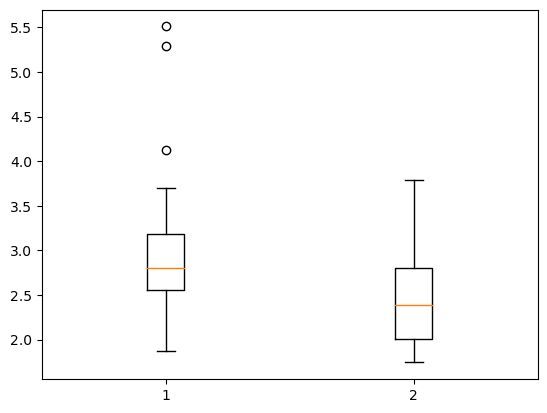

In [39]:
plt.boxplot(data)

In [32]:
mt_800rs = pickle.load(open('/data3/wangkun/mtsim_res/res_1113/linear_/449346/mt_allmuts_mid_0.1_449346_800_rs.pkl', 'rb'))
mt_800 = pickle.load(open('/data3/wangkun/mtsim_res/res_1113/linear_/449346/mt_allmuts_mid_0.1_449346_800.pkl', 'rb'))

In [33]:
mt_800rs = rs_cvt(mt_800rs)
freq_ce = mut_freq(mt_800rs)

# mt_800 = rs_cvt(mt_800)
freq_cm = mut_freq(mt_800)

  0%|          | 0/5155 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:588: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))


In [36]:
np.sum(freq_ce>0.01, axis=1).mean()

1.8721629485935984

(array([1026., 1471., 1075.,  718.,  353.,  183.,  101.,   46.,   25.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

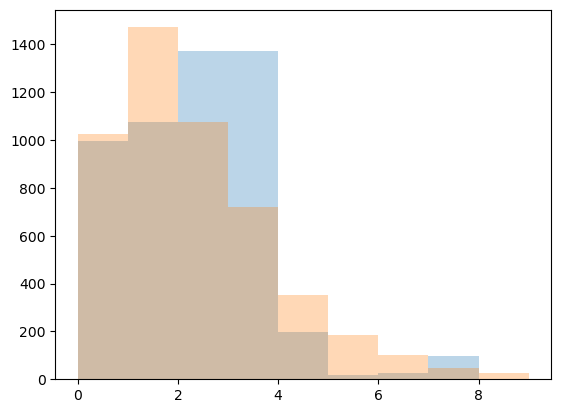

In [34]:
plt.hist(np.sum(freq_ce>0.01, axis=1), alpha=0.3, bins=np.arange(10))
plt.hist(np.sum(freq_cm>0.01, axis=1), alpha=0.3, bins=np.arange(10))